<a href="https://colab.research.google.com/github/KavindaRajapaksha/Brain-Tumor-Detection2024/blob/main/BrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [89]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


dataset link :[link text](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

Reading the images

In [4]:
tumor=[]
path ='/content/drive/MyDrive/dataset/data/brain_tumor_dataset/yes/*.jpg'
for f in glob.iglob(path):
  img=cv2.imread(f)
  img=cv2.resize(img,(128,128))
  b,g,r =cv2.split(img)
  img=cv2.merge([r,g,b])
  tumor.append(img)



In [5]:
healthy=[]
path ='/content/drive/MyDrive/dataset/data/brain_tumor_dataset/no/*.jpg'
for f in glob.iglob(path):
  img=cv2.imread(f)
  img=cv2.resize(img,(128,128))
  b,g,r =cv2.split(img)
  img=cv2.merge([r,g,b])
  healthy.append(img)


In [6]:
len(healthy)

85

In [7]:
healthy=np.array(healthy)
tumor=np.array(tumor)
All=np.concatenate((healthy,tumor))

In [8]:
All.shape

(171, 128, 128, 3)

In [9]:
healthy.shape

(85, 128, 128, 3)

In [10]:
tumor.shape

(86, 128, 128, 3)

In [11]:
np.random.choice(5,3)

array([4, 1, 1])

Visualize Brain MRI Images

In [12]:
def plot_random(healthy,tumor,num=5):
  healthy_imgs=healthy[np.random.choice(healthy.shape[0],num,replace=False)]
  tumor_imgs=tumor[np.random.choice(tumor.shape[0],num,replace=False)]
  plt.figure(figsize=(8,6))
  for i in range(num):
    plt.subplot(1,num,i+1)
    plt.title('healthy')
    plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(8,6))
  for i in range(num):
    plt.subplot(1,num,i+1)
    plt.title('tumor')
    plt.imshow(tumor_imgs[i])

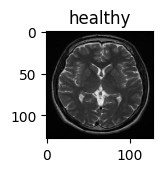

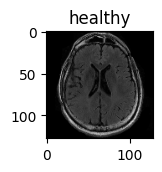

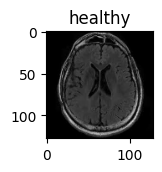

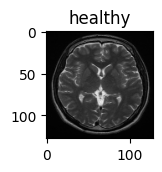

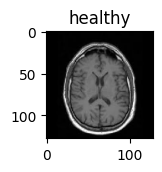

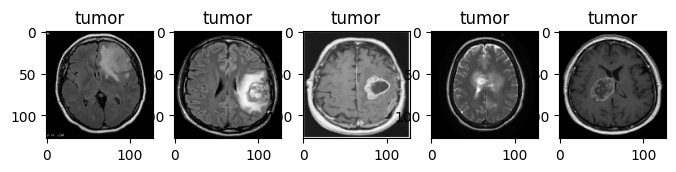

In [15]:
plot_random(healthy,tumor,num=5)

Create Torch Dataset Class

In [58]:
class Dataset(object):


    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

Create custom dataset class

In [118]:
import numpy as np
import glob
import cv2
from torch.utils.data import Dataset

class MRI(Dataset):
    def __init__(self):
        tumor=[]
        path = '/content/drive/MyDrive/dataset/data/brain_tumor_dataset/yes/*.jpg'
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            tumor.append(img)

        healthy=[]
        path = '/content/drive/MyDrive/dataset/data/brain_tumor_dataset/no/*.jpg'
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            healthy.append(img)

        # Convert lists to numpy arrays
        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)

        # Create labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenate images and labels
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):

        sample = {'image': self.images[index], 'label':self.labels[index]}

        return sample

    def normalize(self):
        self.images = self.images/255.0

In [119]:
mri=MRI()

In [120]:
len(mri)

171

In [121]:
mri[5]

{'image': array([[[3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],
 
        [[3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],
 
        [[3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],
 
        ...,
 
        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [3., 3., 3.]],
 
        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [3., 3., 3.]],
 
        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [2., 2., 2.]]], dtype=float32),
 'label': 1.0}

In [122]:
mri_dataset = MRI()
mri_dataset.normalize()

In [123]:
len(mri_dataset)

171

Create the data loader

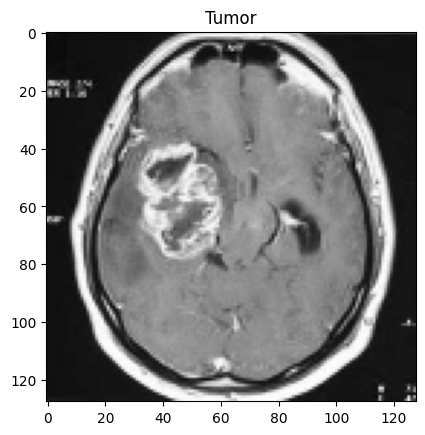

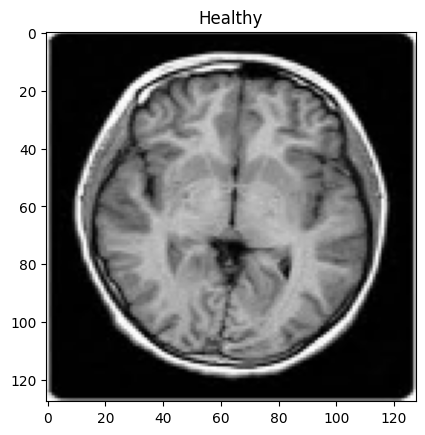

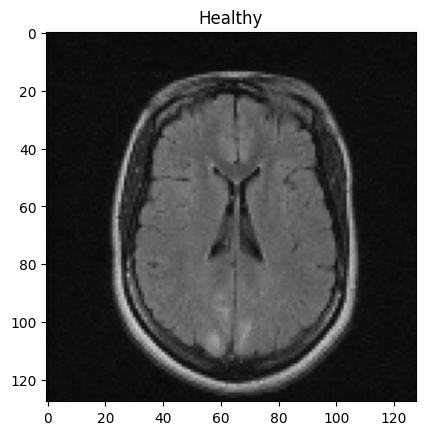

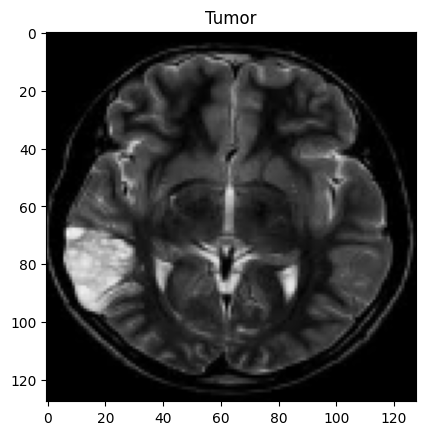

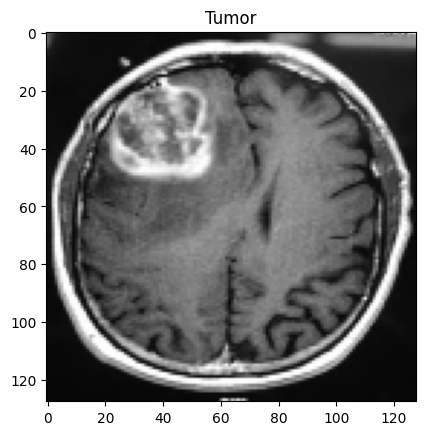

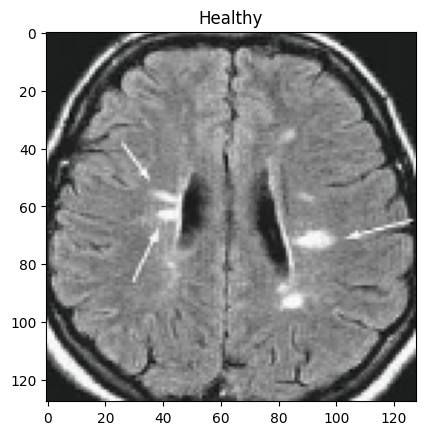

In [143]:



names = {0: 'Healthy', 1: 'Tumor'}


dataloader = DataLoader(mri_dataset, shuffle=True)

# Iterate over the data loader
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()# Transpose the dimensions and convert to NumPy array
    img = img[:, :, [2, 1, 0]]  # Reorder channels from BGR to RGB
    plt.title(names[int(sample['label'].item())])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break


Create a model using CNN

In [175]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x

In [176]:
model=CNN()

In [177]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [178]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

In [179]:
model.cnn_model[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

In [180]:
model.cnn_model[0].weight

Parameter containing:
tensor([[[[ 0.0906,  0.0492,  0.0019,  0.0479, -0.0441],
          [ 0.0386, -0.0404, -0.0589,  0.0182, -0.0243],
          [-0.0055, -0.0630,  0.0519, -0.0157,  0.0612],
          [-0.1005,  0.0929, -0.0192, -0.0537, -0.1104],
          [-0.0198, -0.0257, -0.0399,  0.0243,  0.0505]],

         [[ 0.0118, -0.1153, -0.0950,  0.0940,  0.0536],
          [-0.0035, -0.1102,  0.0091,  0.0523,  0.0224],
          [ 0.0022, -0.0608,  0.1118,  0.0414,  0.1092],
          [-0.0946,  0.1100, -0.0248,  0.0307,  0.0793],
          [ 0.0796, -0.0909, -0.0564,  0.0207, -0.0645]],

         [[ 0.0558,  0.0198,  0.0152,  0.0909, -0.0034],
          [-0.0042, -0.0353, -0.0699, -0.0513,  0.0078],
          [ 0.0526, -0.1016,  0.0068, -0.0032,  0.0852],
          [-0.0563, -0.0093, -0.0254,  0.1022, -0.0269],
          [-0.0121,  0.0303,  0.0739,  0.0471,  0.0064]]],


        [[[-0.1132,  0.0944,  0.0470, -0.1038,  0.0646],
          [-0.0989, -0.0535, -0.0314,  0.0024, -0.0429],
 

In [181]:
model.cnn_model[0].weight.shape

torch.Size([6, 3, 5, 5])

In [182]:
model.cnn_model[0].weight[0].shape

torch.Size([3, 5, 5])

In [183]:
model.cnn_model[0].weight[0][0]

tensor([[ 0.0906,  0.0492,  0.0019,  0.0479, -0.0441],
        [ 0.0386, -0.0404, -0.0589,  0.0182, -0.0243],
        [-0.0055, -0.0630,  0.0519, -0.0157,  0.0612],
        [-0.1005,  0.0929, -0.0192, -0.0537, -0.1104],
        [-0.0198, -0.0257, -0.0399,  0.0243,  0.0505]],
       grad_fn=<SelectBackward0>)

Linear layer

In [184]:
model.fc_model

Sequential(
  (0): Linear(in_features=256, out_features=120, bias=True)
  (1): Tanh()
  (2): Linear(in_features=120, out_features=84, bias=True)
  (3): Tanh()
  (4): Linear(in_features=84, out_features=1, bias=True)
)

In [185]:
model.fc_model[0]

Linear(in_features=256, out_features=120, bias=True)

In [186]:
model.fc_model[0].weight.shape

torch.Size([120, 256])

Understandind x view

In [161]:
x=torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

In [162]:
x=x.reshape((2,2,2,2))

In [163]:
x

tensor([[[[ 1,  2],
          [ 3,  4]],

         [[ 5,  6],
          [ 7,  8]]],


        [[[ 9, 10],
          [11, 12]],

         [[13, 14],
          [15, 16]]]])

In [164]:
x.size(0)

2

In [165]:
x.view(-1)

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

torch.tensor and torch.cuda tensor (as example)

In [187]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.7026, 0.7593, 0.4324, 0.6340, 0.1989, 0.9650, 0.7917, 0.1628, 0.7986,
        0.9580]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.7026, 0.7593, 0.4324, 0.6340, 0.1989, 0.9650, 0.7917, 0.1628, 0.7986,
        0.9580]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.4936, 0.5766, 0.1869, 0.4019, 0.0395, 0.9312, 0.6268, 0.0265, 0.6377,
        0.9178])


Evaluate Nurel network

In [188]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cpu')
model = CNN().to(device)


In [189]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [192]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        # Reshape the input tensor to match the expected shape [batch_size, in_channels, height, width]
        image = image.permute(0, 3, 1, 2)  # Swap dimensions to match [batch_size, channels, height, width]

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())


In [193]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [194]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [195]:
accuracy_score(y_true, threshold(outputs))

0.5029239766081871

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

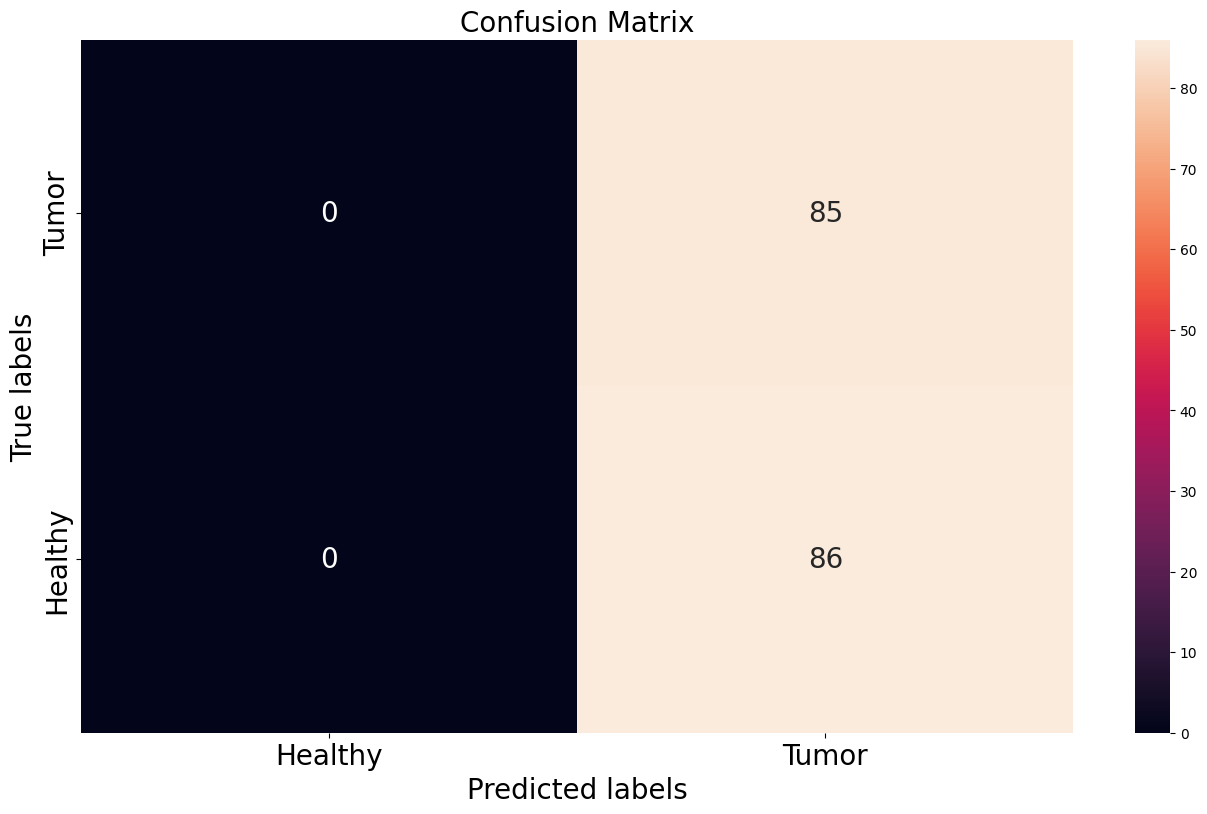

In [196]:
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

In [197]:
from sklearn.metrics import classification_report

# Get classification report
report = classification_report(y_true, threshold(outputs), target_names=['Healthy', 'Tumor'])

# Print classification report
print(report)


              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        85
       Tumor       0.50      1.00      0.67        86

    accuracy                           0.50       171
   macro avg       0.25      0.50      0.33       171
weighted avg       0.25      0.50      0.34       171



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


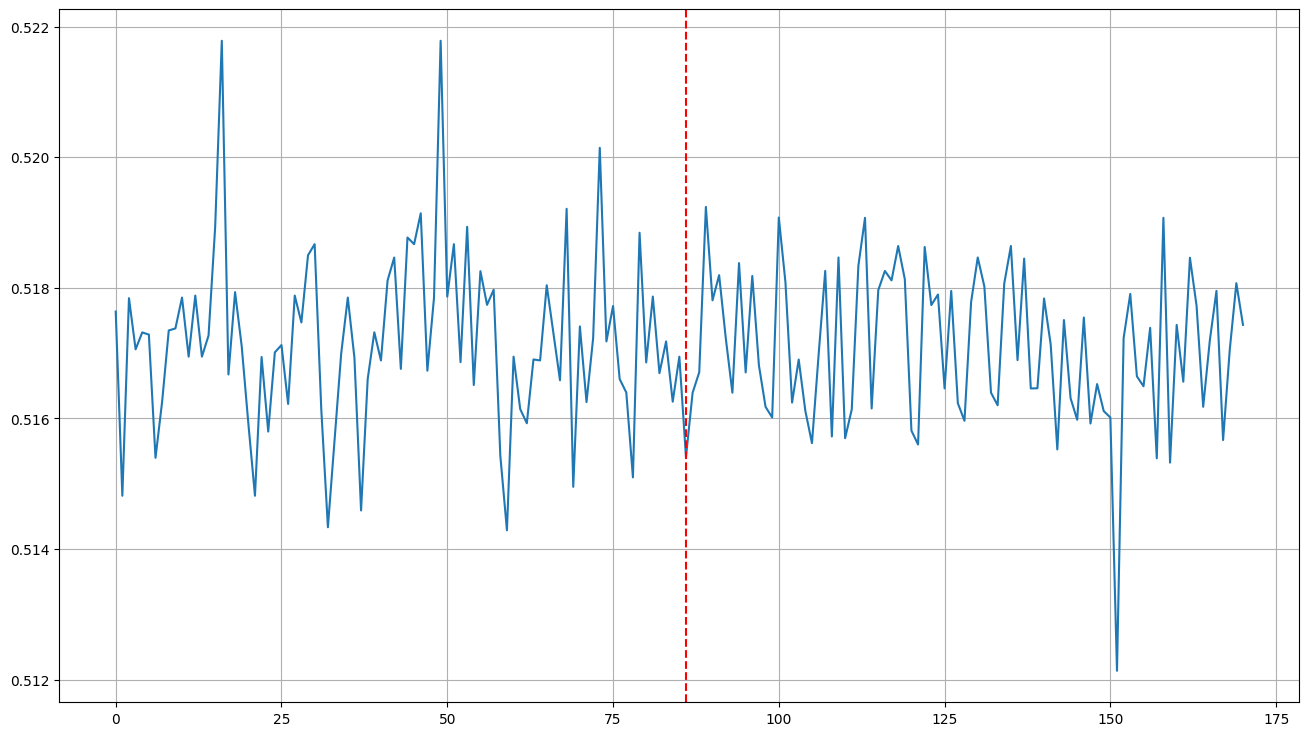

In [198]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

Train the Dumb model

In [199]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [201]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        data = data.permute(0, 3, 1, 2)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.685918
Train Epoch: 20	Loss: 0.610847
Train Epoch: 30	Loss: 0.564309
Train Epoch: 40	Loss: 0.535047
Train Epoch: 50	Loss: 0.538402
Train Epoch: 60	Loss: 0.524187
Train Epoch: 70	Loss: 0.495433
Train Epoch: 80	Loss: 0.509943
Train Epoch: 90	Loss: 0.466134
Train Epoch: 100	Loss: 0.435787
Train Epoch: 110	Loss: 0.407895
Train Epoch: 120	Loss: 0.392066
Train Epoch: 130	Loss: 0.379042
Train Epoch: 140	Loss: 0.360254
Train Epoch: 150	Loss: 0.340358
Train Epoch: 160	Loss: 0.302288
Train Epoch: 170	Loss: 0.262297
Train Epoch: 180	Loss: 0.265460
Train Epoch: 190	Loss: 0.257814
Train Epoch: 200	Loss: 0.239954
Train Epoch: 210	Loss: 0.221634
Train Epoch: 220	Loss: 0.189224
Train Epoch: 230	Loss: 0.170975
Train Epoch: 240	Loss: 0.169966
Train Epoch: 250	Loss: 0.140950
Train Epoch: 260	Loss: 0.131154
Train Epoch: 270	Loss: 0.107672
Train Epoch: 280	Loss: 0.087820
Train Epoch: 290	Loss: 0.087950
Train Epoch: 300	Loss: 0.071148
Train Epoch: 310	Loss: 0.062004
Train Epoch: 320	

Evaluate the smart model

In [203]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        image = image.permute(0, 3, 1, 2)  # Swap dimensions to match [batch_size, channels, height, width]
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)


In [204]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

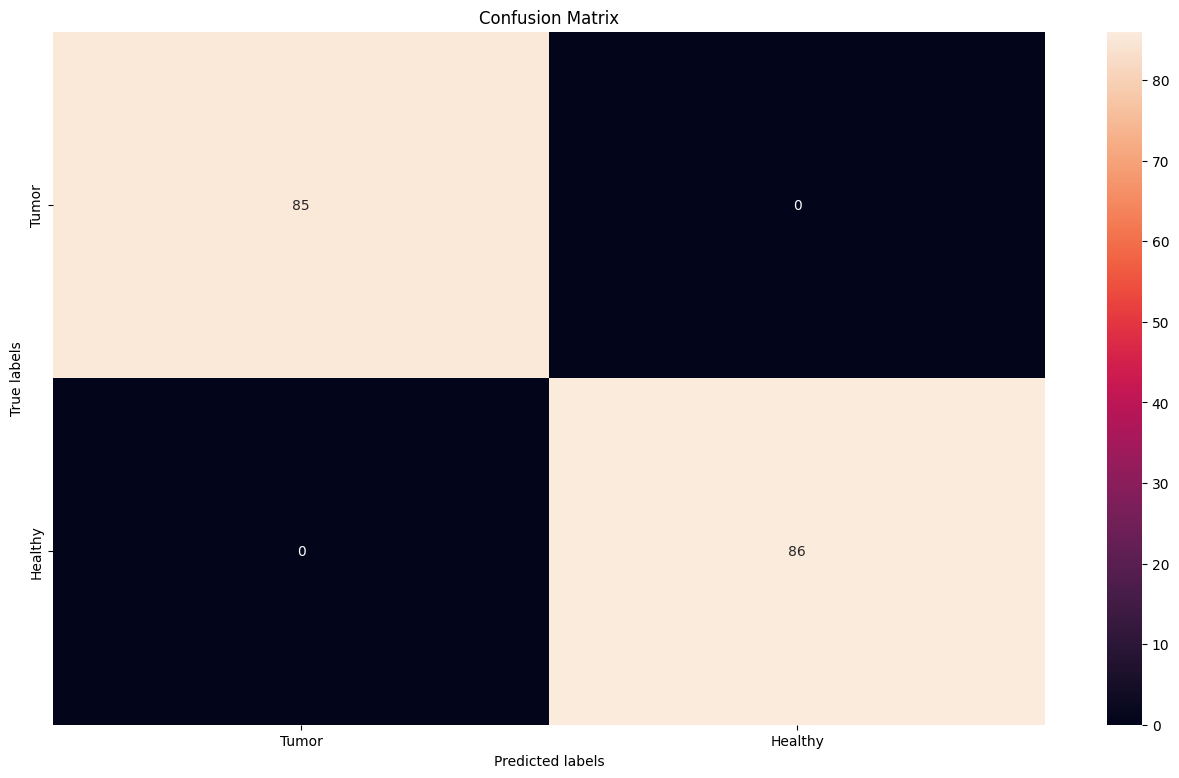

In [205]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

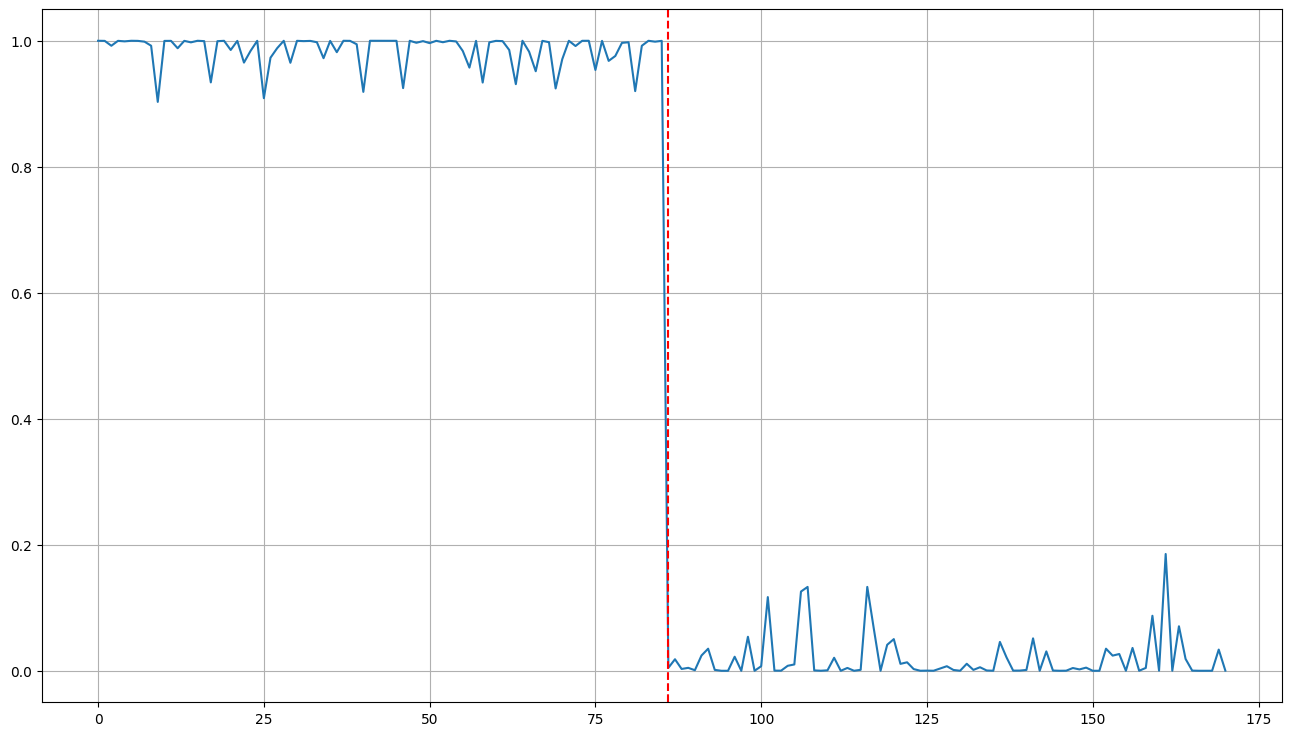

In [206]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

Visualizing the Feature Maps of the convolution filters

In [207]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [208]:
no_of_layers = 0
conv_layers = []

In [209]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [210]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [211]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

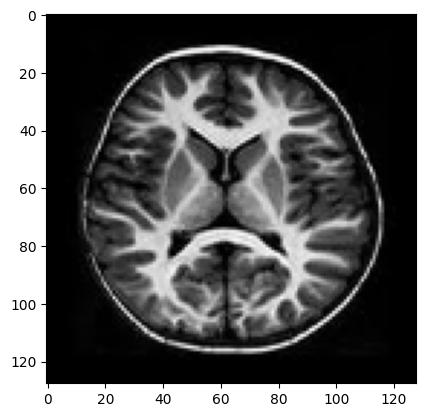

In [212]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [213]:
img = torch.from_numpy(img).to(device)

In [214]:
img.shape

torch.Size([128, 128, 3])

In [215]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 128, 128, 3])

In [217]:
# Assuming img is your input tensor and conv_layers is a list of convolutional layers
img = img.permute(0, 3, 1, 2)  # Swap dimensions to match [batch_size, channels, height, width]

results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results


Layer  1


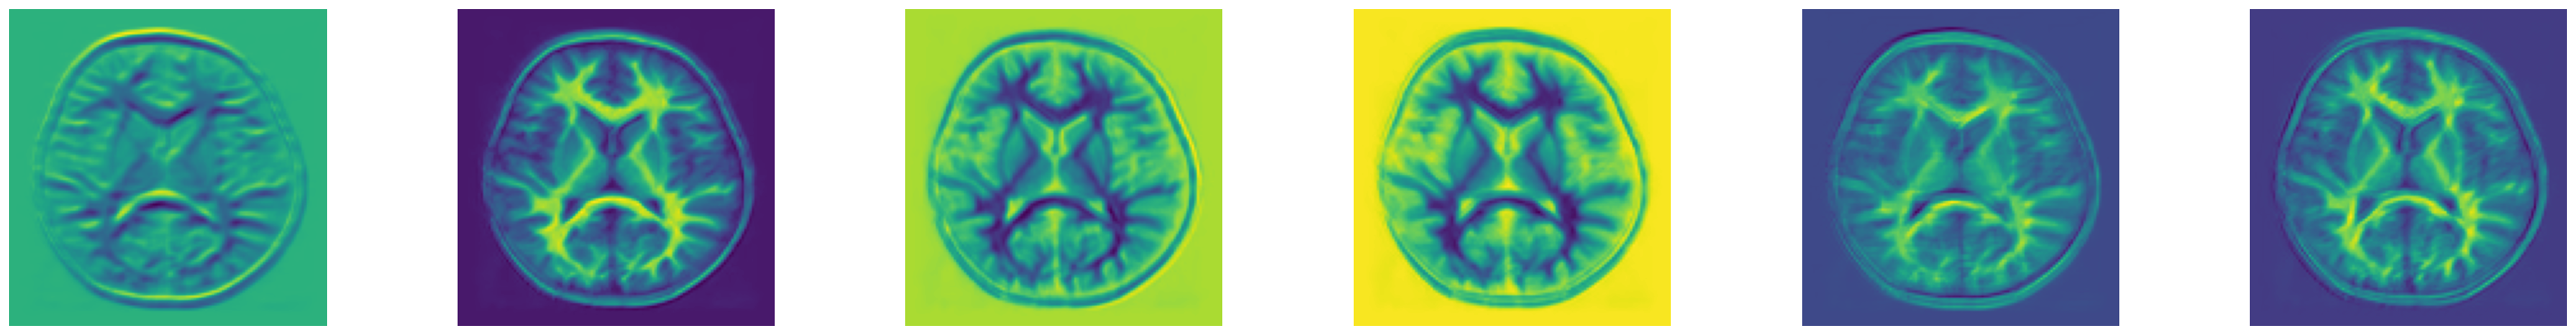

Layer  2


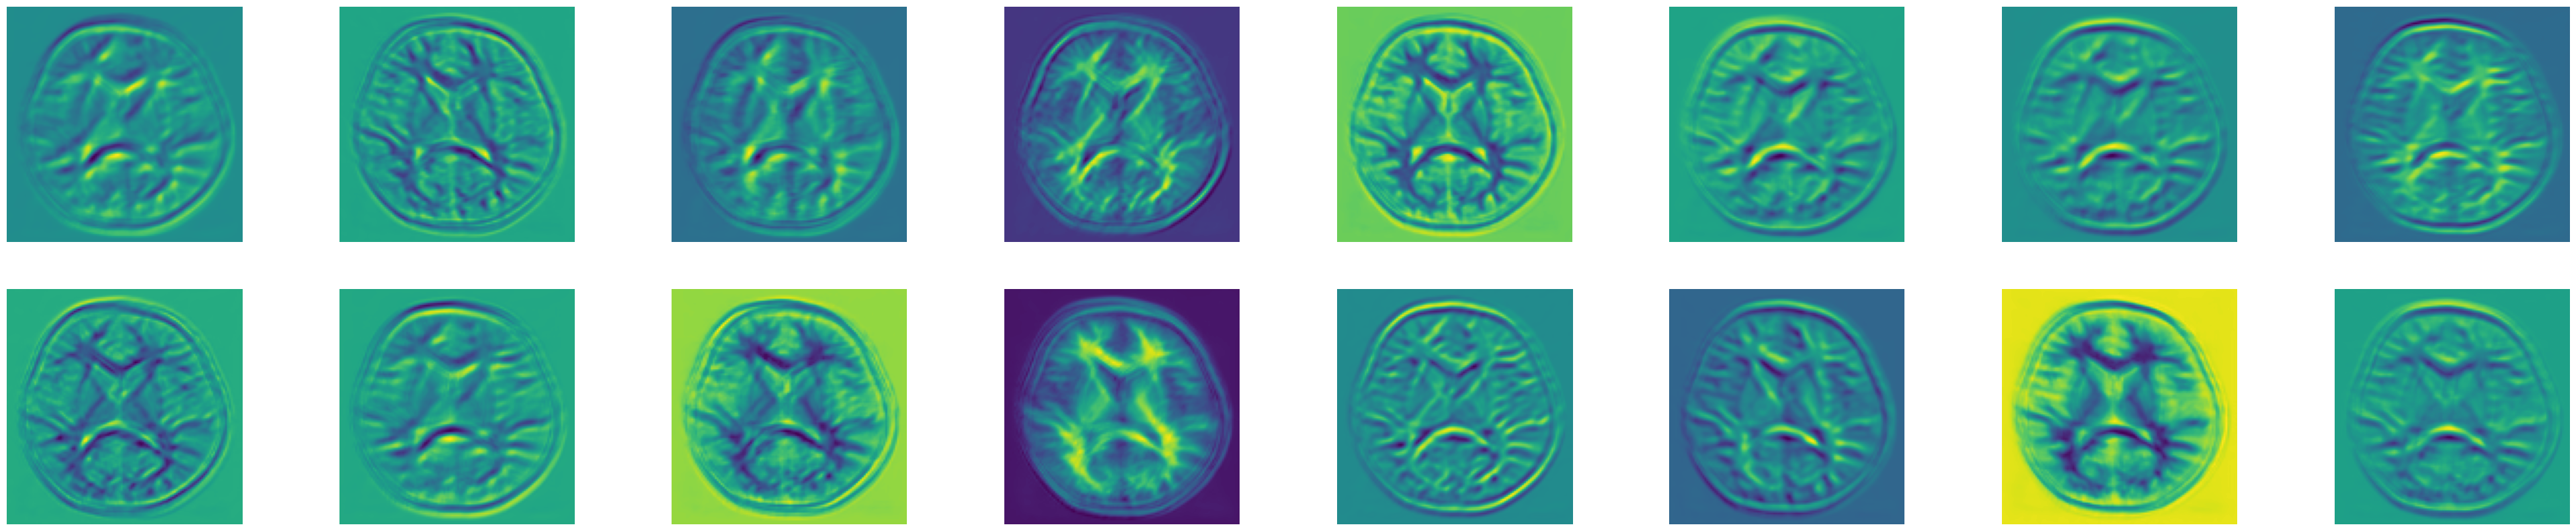

In [218]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

Check overfitting or not

In [219]:
from sklearn.model_selection import train_test_split

In [235]:
class MRI(Dataset):

    def __init__(self):

        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None

        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'

        tumor=[]
        path = '/content/drive/MyDrive/dataset/data/brain_tumor_dataset/yes/*.jpg'
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            tumor.append(img)

        healthy=[]
        path = '/content/drive/MyDrive/dataset/data/brain_tumor_dataset/no/*.jpg'
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            healthy.append(img)


        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
           train_test_split(self.images, self.labels, test_size=0.20, random_state=42)


    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]

    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}

        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}

        return sample

    def normalize(self):
        self.images = self.images/255.0

In [236]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()  # Call train_val_split method before creating data loaders

train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)


In [237]:
device = torch.device("cpu")
model = CNN().to(device)

In [238]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [239]:
epoch_train_loss = []
epoch_val_loss = []

In [242]:
for epoch in range(1, 600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        # Adjust the shape of the input data
        data = data.permute(0, 3, 1, 2)  # Swap dimensions to match [batch_size, channels, height, width]
        label = D['label'].to(device)

        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))

    # validate for the current epoch
    val_losses = []
    model.eval()

    mri_dataset.mode = 'val'

    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            # Adjust the shape of the input data
            data = data.permute(0, 3, 1, 2)  # Swap dimensions to match [batch_size, channels, height, width]
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())

    epoch_val_loss.append(np.mean(val_losses))

    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))


Train Epoch: 10	Train Loss: 0.678130	Val Loss: 0.681729
Train Epoch: 20	Train Loss: 0.621119	Val Loss: 0.645791
Train Epoch: 30	Train Loss: 0.595969	Val Loss: 0.592780
Train Epoch: 40	Train Loss: 0.562087	Val Loss: 0.576044
Train Epoch: 50	Train Loss: 0.544663	Val Loss: 0.580944
Train Epoch: 60	Train Loss: 0.546539	Val Loss: 0.568404
Train Epoch: 70	Train Loss: 0.519422	Val Loss: 0.559124
Train Epoch: 80	Train Loss: 0.557268	Val Loss: 0.562610
Train Epoch: 90	Train Loss: 0.572936	Val Loss: 0.577530
Train Epoch: 100	Train Loss: 0.488677	Val Loss: 0.556478
Train Epoch: 110	Train Loss: 0.521964	Val Loss: 0.531070
Train Epoch: 120	Train Loss: 0.560432	Val Loss: 0.543305
Train Epoch: 130	Train Loss: 0.507269	Val Loss: 0.512211
Train Epoch: 140	Train Loss: 0.470003	Val Loss: 0.494472
Train Epoch: 150	Train Loss: 0.430998	Val Loss: 0.475361
Train Epoch: 160	Train Loss: 0.477014	Val Loss: 0.514738
Train Epoch: 170	Train Loss: 0.446124	Val Loss: 0.487951
Train Epoch: 180	Train Loss: 0.404621	Va

Text(0, 0.5, 'Loss')

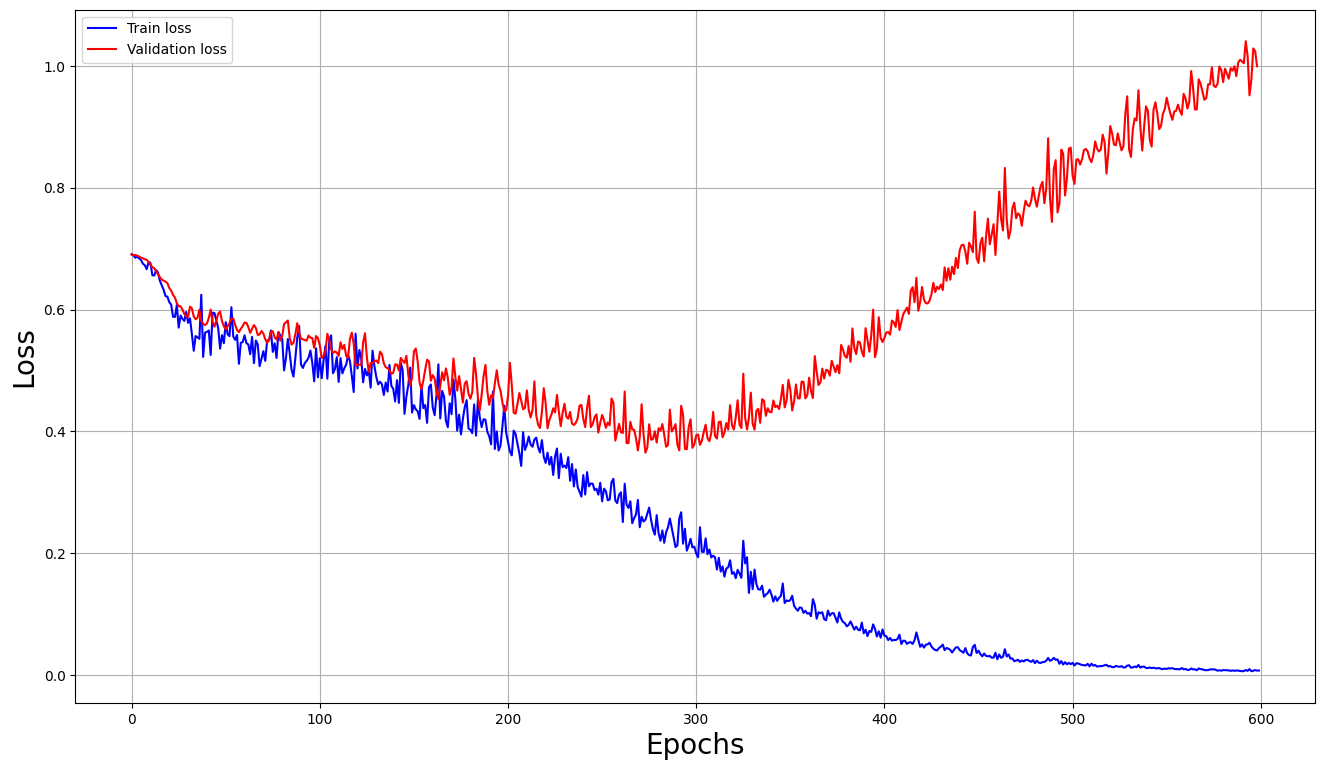

In [243]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)